## PaleoSTeHM: A modern, scalable Spatio-Temporal Hierarchical Modeling framework for paleo-environmental data

Yucheng Lin - yc.lin@rutgers.edu

with Alex Reedy and Robert Kopp

### Spatio-temporal Gassusian Process Modelling Tutorial


In [1]:
#load modules
import os
import matplotlib.pyplot as plt
import matplotlib
import torch
import numpy as np
import pandas as pd
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
import sys
sys.path.append('../Code')
import PSTHM 
import time
import seaborn as sns
from scipy import interpolate
smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.8.4')
pyro.set_rng_seed(0) #set random seed used in this notebook

#set plotting style
%matplotlib inline
font = {'weight':'normal',
       'size':20}

matplotlib.rc('font',**font)
matplotlib.rcParams['figure.figsize'] = (12, 6)
import warnings
warnings.filterwarnings("ignore")

In [2]:
US_data = pd.read_csv('../Data/US_Atlantic_Coast_for_ESTGP.csv')
US_rsl = US_data['RSL']
US_rsl_2sd =( US_data['RSLer_up_2sd']+US_data['RSLer_low_2sd'])/2 #average up and low 2std
US_rsl_age = -(US_data['Age']-1950) #convert age from BP to CE
US_rsl_age_2sd = (US_data['Age_low_er_2sd']+US_data['Age_up_er_2sd'])/2 #average up and low 2std

US_lon = US_data['Longitude']
US_lat = US_data['Latitude']
US_coord = np.vstack((US_lat,US_lon)).T

age = torch.tensor(US_rsl_age)
coord = torch.tensor(US_coord)
y = torch.tensor(US_rsl)
y_sigma = torch.tensor(US_rsl_2sd/2).flatten()
x_sigma = torch.tensor(US_rsl_age_2sd/2).flatten()
X = torch.hstack([age[:,None],coord])



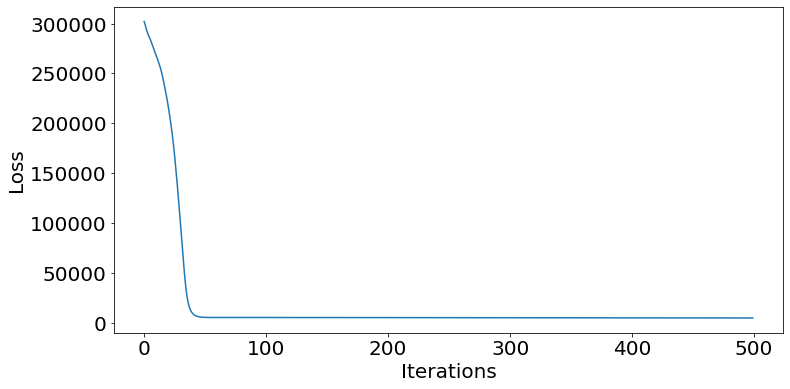

In [42]:
pyro.clear_param_store()
spatial_RBF  = PSTHM.RBF(input_dim=1,variance=torch.tensor(0.1),s_lengthscale=torch.tensor(0.01),geo=True)
spatial_RBF.set_prior("s_lengthscale", dist.Uniform(torch.tensor(1e-2), torch.tensor(1.)))

temporal_RBF  = PSTHM.RBF(input_dim=1,variance=torch.tensor(1),lengthscale=torch.tensor(1000),geo=False)
SP_kernel = gp.kernels.Product(temporal_RBF, spatial_RBF)

gpr = PSTHM.GPRegression_V(X, y, SP_kernel,noise=torch.tensor(y_sigma**2),jitter=1e-5)
gpr = gpr.double()
#optimize RBF kernel with Adam optimizer
optimizer = torch.optim.Adam(gpr.parameters(), lr=0.1)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
variance_track,lengthscale_track,s_lengthscale_track = [],[],[]

num_steps = 500 if not smoke_test else 2

for i in range(num_steps):

    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    gpr.set_mode("guide")
    variance_track.append(temporal_RBF.variance.item())
    lengthscale_track.append(temporal_RBF.lengthscale.item())
    s_lengthscale_track.append(spatial_RBF.s_lengthscale.item())

PSTHM.plot_loss(losses)

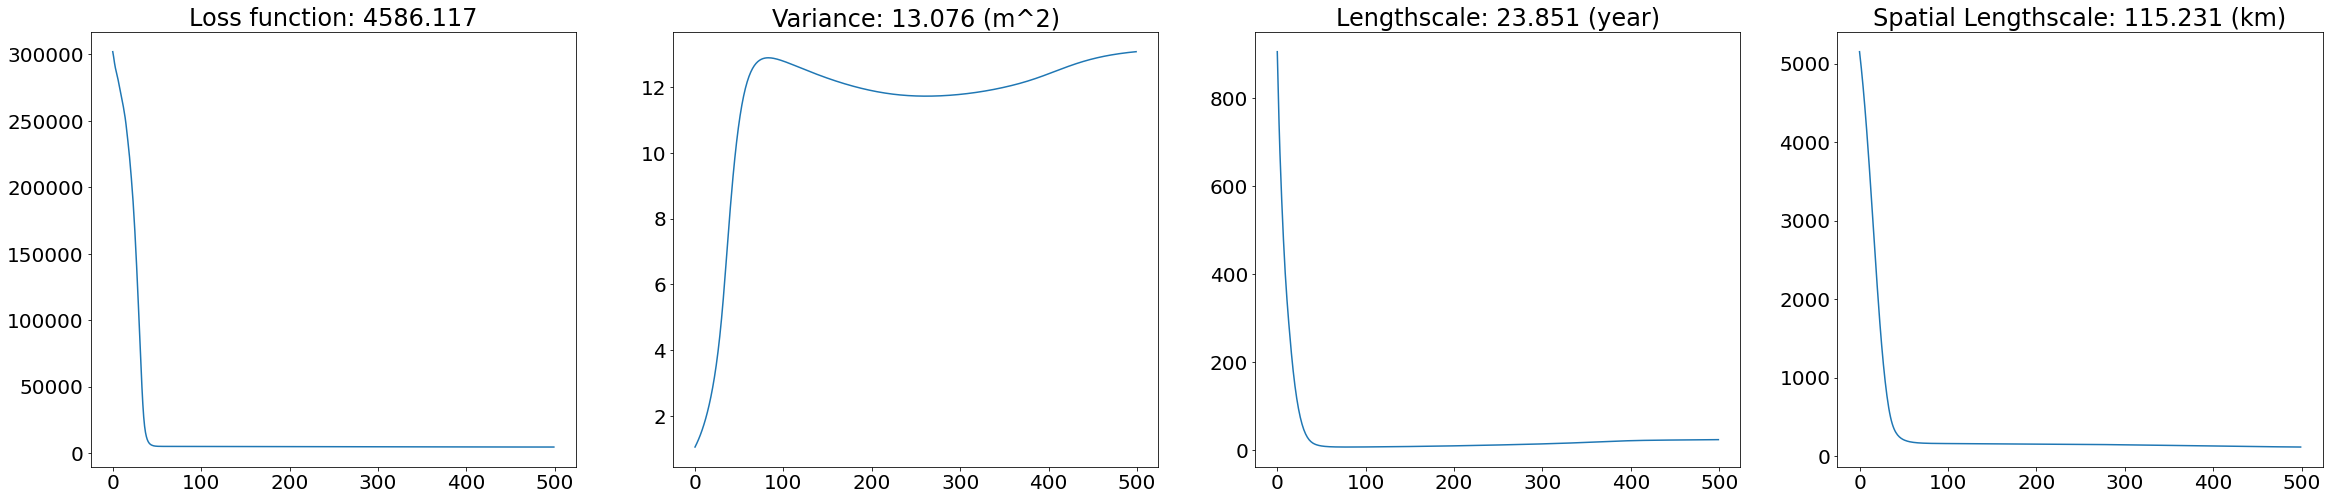

In [43]:
fig= plt.figure(figsize=(40, 8))
plt.subplot(141)
plt.plot(np.arange(len(losses)),losses)
plt.title('Loss function: {:5.3f}'.format(losses[-1]))
plt.subplot(142)
plt.plot(np.arange(len(variance_track)),np.array(variance_track)**0.5)
plt.title('Variance: {:5.3f} (m^2)'.format(variance_track[-1]**0.5))

plt.subplot(143)
plt.plot(np.arange(len(lengthscale_track)),lengthscale_track)
plt.title('Lengthscale: {:5.3f} (year)'.format(lengthscale_track[-1]))

plt.subplot(144)
plt.plot(np.arange(len(s_lengthscale_track)),np.array(s_lengthscale_track)*6371)
plt.title('Spatial Lengthscale: {:5.3f} (km)'.format(s_lengthscale_track[-1]*6371));

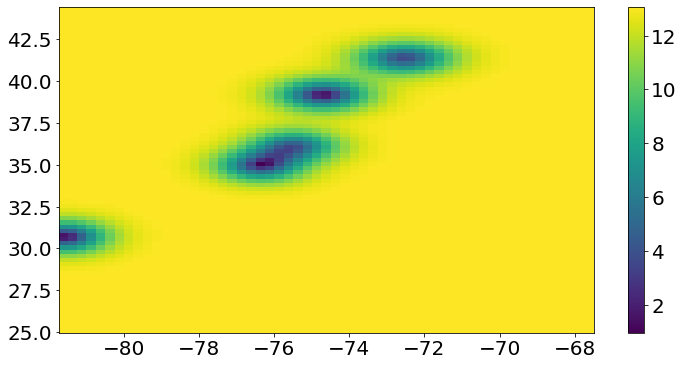

In [50]:
from pyro.contrib.gp.util import conditional

x_test = torch.arange(-500,2025,5.)
lon_test = np.arange(np.min(US_lon),np.max(US_lon),0.25)
lat_test = np.arange(np.min(US_lat),np.max(US_lat),0.25)
lon_matrix,lat_matrix = np.meshgrid(lon_test,lat_test)
test_X = torch.tensor(np.hstack([np.ones(len(lon_matrix.flatten()))[:,None]*-2000,lat_matrix.flatten()[:,None],lon_matrix.flatten()[:,None]]))
test_X2 = torch.tensor(np.hstack([np.ones(len(lon_matrix.flatten()))[:,None]*2000,lat_matrix.flatten()[:,None],lon_matrix.flatten()[:,None]]))

y_mean, y_var = gpr(test_X.double(), full_cov=True)
y_mean2, y_var2 = gpr(test_X2.double(), full_cov=True)
y_std = y_var.diag().sqrt()
y_std2 = y_var2.diag().sqrt()

plt.pcolor(lon_matrix,lat_matrix,(y_std2).detach().numpy().reshape(lon_matrix.shape))
plt.colorbar()
# plt.scatter(X[:,2],X[:,1])

In [38]:
y_mean

tensor([-6.4984e-06, -6.7063e-06, -6.8441e-06,  ..., -2.2216e-08,
        -1.8535e-08, -1.5354e-08], dtype=torch.float64, grad_fn=<AddBackward0>)